# Automathon 2024

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.io as io
import os
import json
from tqdm import tqdm
import csv
import timm
import wandb

from PIL import Image
import torchvision.transforms as transforms

/Users/neosapien/Development/automathon/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utilities

In [2]:
import matplotlib.pyplot as plt

def display_image(img):
    img = img.permute(1,2,0)
    plt.imshow(img)

def smart_resize(data, size): # kudos louis
    # Prends un tensor de shape [...,C,H,W] et le resize en [C,new_height,new_width]
    # x, y, height et width servent a faire un crop avant de resize

    full_height = data.shape[-2]
    full_width = data.shape[-1]

    if full_height > full_width:
        alt_height = size
        alt_width = int(full_width * full_height / size)
    elif full_height < full_width:
        alt_height = int(full_height * full_width / size)
        alt_width = size
    else:
        alt_height = size
        alt_width = size
    tr = transforms.Compose([
        transforms.Resize((alt_height, alt_width)),
        transforms.CenterCrop(size)
    ])
    return tr(data)

def resize_data(data, new_height, new_width, x=0, y=0, height=None, width=None):
    # Prends un tensor de shape [...,C,H,W] et le resize en [C,new_height,new_width]
    # x, y, height et width servent a faire un crop avant de resize
    
    full_height = data.shape[-2]
    full_width = data.shape[-1]
    height = full_height - y if height is None else height
    width = full_width -x if width is None else width

    ratio = new_height/new_width
    if height/width > ratio:
        expand_height = height
        expand_width = int(height / ratio)
    elif height/width < ratio:
        expand_height = int(width * ratio)
        expand_width = width
    else:
        expand_height = height
        expand_width = width
    tr = transforms.Compose([
        transforms.CenterCrop((expand_height, expand_width)),
        transforms.Resize((new_height, new_width))
    ])
    x = data[...,y:min(y+height, full_height), x:min(x+width, full_width)].clone()
    return tr(x)

## Setup du Dataset

In [3]:

dataset_dir = "/raid/datasets/hackathon2024"
root_dir = os.path.expanduser("/kaggle/input/automathon-deepfake/dataset/experimental_dataset")

nb_frames = 10

class VideoDataset(Dataset):
    """
    This Dataset takes a video and returns a tensor of shape [10, 3, 256, 256]
    That is 10 colored frames of 256x256 pixels.
    """
    def __init__(self, root_dir, dataset_choice="train", nb_frames=10):
        super().__init__()
        self.dataset_choice = dataset_choice
        if  self.dataset_choice == "train":
            self.root_dir = os.path.join(root_dir, "train_dataset")
        elif  self.dataset_choice == "test":
            self.root_dir = os.path.join(root_dir, "test_dataset")
        elif  self.dataset_choice == "experimental":
            self.root_dir = os.path.join(root_dir, "experimental_dataset")
        else:
            raise ValueError("choice must be 'train', 'test' or 'experimental'")

        with open(os.path.join(root_dir, "dataset.csv"), 'r') as file:
            reader = csv.reader(file)
            # read dataset.csv with id,label columns to create
            # a dict which associated label: id
            self.ids = {row[1][:-3] + "pt" : row[0] for row in reader}

        if self.dataset_choice == "test":
            self.data = None
        else:
            with open(os.path.join(self.root_dir, "metadata.json"), 'r') as file:
                self.data= json.load(file)
                self.data = {k[:-3] + "pt" : (torch.tensor(float(1)) if v == 'FAKE' else torch.tensor(float(0))) for k, v in self.data.items()}

        #self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.mp4')]
        self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.pt')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        #video, audio, info = io.read_video(video_path, pts_unit='sec')
        video = torch.load(video_path)
        '''
        video = video.permute(0,3,1,2)
        length = video.shape[0]
        video = video[[i*(length//(nb_frames)) for i in range(nb_frames)]]
        '''
        # resize the data into a reglar shape of 256x256 and normalize it
        #video = smart_resize(video, 256) / 255
        video = video / 255

        ID = self.ids[self.video_files[idx]]
        if self.dataset_choice == "test":
            return video, ID
        else:
            label = self.data[self.video_files[idx]]
            return video, label, ID



#train_dataset = VideoDataset(dataset_dir, dataset_choice="train", nb_frames=nb_frames)
test_dataset = VideoDataset(dataset_dir, dataset_choice="test", nb_frames=nb_frames)
experimental_dataset = VideoDataset(dataset_dir, dataset_choice="experimental", nb_frames=nb_frames)


Voici comment afficher un frame du dataset:

tensor(0.)
torch.Size([10, 3, 256, 256])


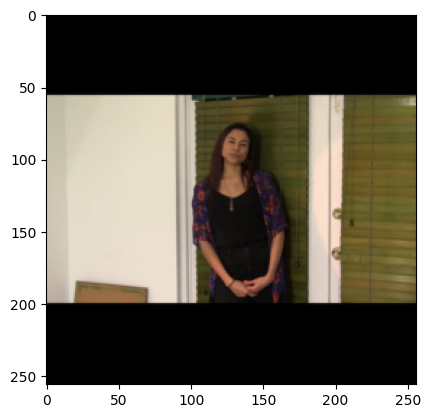

In [61]:
video, label, ID = experimental_dataset[0]
img = video[0]

display_image(img)
print(label)
print(video.shape)

Et comment faire un resize

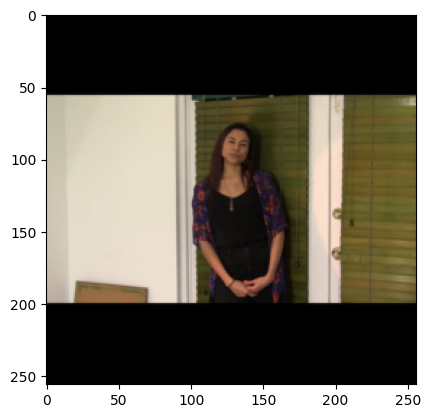

In [4]:
video, label, ID = experimental_dataset[0]
img=video[0]

img=smart_resize(img, 256)
display_image(img)

## Modèle

In [83]:
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10):
        super().__init__()
        self.dense = nn.Linear(nb_frames*3*256*256,1)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.flat(x)
        y = self.dense(y)
        y = self.sigmoid(y)
        return y


model = DeepfakeDetector(nb_frames=nb_frames)

video, label, ID = experimental_dataset[0]
video = video.unsqueeze(0) # add a batch dimension
summary(model, input_size=video.shape)

Layer (type:depth-idx)                   Output Shape              Param #
DeepfakeDetector                         [1, 1]                    --
├─Flatten: 1-1                           [1, 1966080]              --
├─Linear: 1-2                            [1, 1]                    1,966,081
├─BatchNorm1d: 1-3                       [1, 1]                    2
Total params: 1,966,083
Trainable params: 1,966,083
Non-trainable params: 0
Total mult-adds (M): 1.97
Input size (MB): 7.86
Forward/backward pass size (MB): 0.00
Params size (MB): 7.86
Estimated Total Size (MB): 15.73

## Logging

In [77]:
wandb.login(key="a446d513570a79c857317c3000584c5f6d6224f0")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [78]:
run = wandb.init(
    project="automathon",
    name="nom-de-votre-equipe",
    config={
        "learning_rate": 0.001,
        "architecture": "-",
        "dataset": "DeepFake Detection Challenge",
        "epochs": 10,
        "batch_size": 10,
    },
)

## Entrainement

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.MSELoss()
model = DeepfakeDetector().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
nb_epochs = 5
loader = DataLoader(experimental_dataset, batch_size=2, shuffle=True)

for epoch in range(nb_epochs):
    for sample in tqdm(loader, desc="Epoch {}".format(epoch), ncols=0):
        optimizer.zero_grad()
        X, label, ID = sample
        X = X.to(device)
        label = label.to(device)
        label_pred = model(X)
        label=torch.unsqueeze(label,dim=1)
        loss = loss_fn(label, label_pred)
        loss.backward()
        optimizer.step()
        run.log({"loss": loss.item(), "epoch": epoch})

Epoch 0:   2% 118/4957 [05:31<3:46:48,  2.81s/it]


KeyboardInterrupt: 

## Test

In [87]:

loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
model = model.to(device)
ids = []
labels = []
print("Testing...")
for sample in tqdm(loader):
    X, ID = sample
    #ID = ID[0]
    X = X.to(device)
    label_pred = model(X)
    ids.extend(list(ID))
    pred = (label_pred > 0.5).long()
    pred = pred.cpu().detach().numpy().tolist()
    labels.extend(pred)


 12%|█▏        | 66/557 [02:21<17:29,  2.14s/it]


IndexError: index 153 is out of bounds for dimension 0 with size 153

### Saving

In [ ]:
print("Saving...")
tests = ["id,label\n"] + [f"{ID},{label_pred[0]}\n" for ID, label_pred in zip(ids, labels)]
with open("submission.csv", "w") as file:
    file.writelines(tests)
